## 데이콘 로그 분석을 통한 보안 위험도 예측 AI 경진대회
새롭게 설치된 서버, NW 장비에서 발생되는 로그, 패킷에 대한 룰이 없으므로, 이에 대하여 인공지능으로 침해 위험도를 8단계로 분류하고자 합니다.

침해 위험도는 새로운 형태의 침해 시에, 프로세스의 동작패턴, 명령어의 사용 종류가 달라지므로, 이에 대한 인공지능 침해탐지, 위험도를 분류해야합니다.

기존에 확인된 위험요소는 위험도를 0~6 7단계로 분류하였고 새로운 위험 요소를 위험도 7로 하여 총 8단계 분류합니다.  

# 1. 베이스라인
## 라이브러리 & 데이터 EDA

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [5]:
print(train.shape, test.shape, submission.shape)
train.head()
test.head()

(472972, 3) (1418916, 2) (1418916, 2)


,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


,id,full_log
0,1000000,"Feb 8 15:47:26 localhost kibana: {""type"":""err..."
1,1000001,"Sep 24 03:46:39 localhost kibana: {""type"":""err..."
2,1000002,type=SYSCALL msg=audit(1611888200.428:210563):...
3,1000003,"Jan 18 11:24:06 localhost kibana: {""type"":""err..."
4,1000004,type=SYSCALL msg=audit(1603081202.050:46851): ...


<AxesSubplot:>

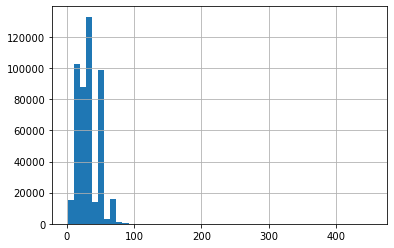

In [6]:
#train full_log의 길이 확인
train['full_log'].str.split(' ').str.len().hist(bins=50)

In [7]:
#train level별 값 확인
train['level'].value_counts()

0    334065
1    132517
3      4141
5      2219
2        12
4        10
6         8
Name: level, dtype: int64

## 데이터 전처리

In [8]:
#full_log에서 숫자는 마스킹 처리
train['full_log']=train['full_log'].str.replace(r'[0-9]', '<num>')
test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

In [9]:
#train['full_log'] => train_text로 list
#train['level']=> train_level로 array
train_text=list(train['full_log'])
train_level=np.array(train['level'])

In [10]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features=vectorizer.fit_transform(train_text)
train_features

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

## 모델링

In [11]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

train_x, eval_x, train_y, eval_y=train_test_split(train_features, train_level, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [12]:
#랜덤포레스트로 모델링
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100)
forest.fit(train_x, train_y)

RandomForestClassifier()

In [13]:
forest.score(eval_x, eval_y)

0.9979280088799619

In [14]:
pred=forest.predict(eval_x)
crosstab = pd.crosstab(eval_y, pred, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,2,3,4,5
real,,,,,,
0,66729,55,0,0,0,2
1,118,26428,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,13,2,0,0,0,438
6,1,0,0,2,0,0


In [15]:
# 예측치의 예측 확률이 0.90이하인 경우, 즉 확신이 없을 경우 이상치로 판단
preds=forest.predict(eval_x)
probas=forest.predict_proba(eval_x)
print(preds.shape)
print(probas.shape)

preds[np.where(np.max(probas, axis=1)<0.90)]=7
new_crosstab = pd.crosstab(eval_y, preds, rownames=['real'], colnames=['pred'])
new_crosstab

(94595,)
(94595, 7)


pred,0,1,2,3,4,5,7
real,,,,,,,
0,66516,0,0,0,0,0,270
1,21,26407,0,0,0,0,119
2,0,0,2,0,0,0,0
3,0,0,0,793,0,0,8
4,0,0,0,0,3,0,0
5,4,0,0,0,0,435,14
6,0,0,0,0,0,0,3


## 예측

In [16]:
test_text=list(test['full_log'])
ids=list(test['id'])

In [17]:
#test 데이터 vectorizer
#주의: fit_transform의 경우 data leakage에 위반될 수 있습니다
test_features=vectorizer.transform(test_text)

In [18]:
results=forest.predict(test_features)
results_proba=forest.predict_proba(test_features)
results[np.where(np.max(results_proba, axis=1) < 0.9)] = 7

In [19]:
submission['level']=results
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [ ]:
#submission.to_csv('baseline_submission.csv', index=False)

# 2. 우수 코드

In [20]:
import pandas as pd
import numpy as np
import os 
import pandas as pds
from dask import dataframe
import re
import numpy as np
import seaborn as sbn
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet

train = pd.read_csv("train.csv")
test= pd.read_csv("test.csv")

In [21]:
#  다양한 기호 및 숫자 제거
lit = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
def mask(tt):
    tt=tt.apply(lambda x: re.sub(r'(\\n)',' ',x))
    tt=tt.apply(lambda x: re.sub(r'[^a-zA-Zㄱ-ㅣ가-힣0-9:=\s\(\)./,\<\>]+',' ',x))
    #tt=tt.apply(lambda x: re.sub(r' ?(?P<note>[:=\(\)./,\<\>]) ?', ' \g<note> ', x))
    tt=tt.apply(lambda x: re.sub(r'[0-9]+',' ',x))
    tt=tt.apply(lambda x: re.sub(r"':/()",' ',x))
    tt=tt.apply(lambda x: re.sub(r':',' ',x))
    tt=tt.apply(lambda x: re.sub(r',',' ',x))
    # = tt.apply(lambda x: re.sub(r'(',' ',x))
    #t = tt.apply(lambda x: re.sub(r')',' ',x))
    tt=tt.apply(lambda x: re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]',' ',x))
    for st in lit:
        st = " "+st + " "
        tt=tt.apply(lambda x: re.sub(st,' ',x))
    tt=tt.apply(lambda x: re.sub(r'\s+',' ',x))
    
    return tt

train['pre_log'] = mask(train.full_log)
test['pre_log'] = mask(test.full_log)

In [22]:
# 영어 단어가 아니거나 3글자 미만인지인 경우에는 삭제
def count_word(data):
    tem = list(data['pre_log'].str.split(" "))
    all_word = []
    for word in tem:
        all_word.extend(word)
    words = pd.Series(all_word)
    return words.value_counts()

In [23]:
train_count = count_word(train)
test_count = count_word(test)
train_words = list(set(train_count.index))
test_words = list(set(test_count.index))

In [24]:
#영어 단어 + 3글자 이상인 경우만 True
from nltk.corpus import words
def check_words(word_list: list):
    re = [False] * len(word_list)
    for i,word in enumerate(word_list):
        if len(word) < 3:
            continue
        word = word.lower()
        if word in words.words():
            re[i] = True
    return re

word_list = ['Promiscuous', 'ab', 'nihongo', 'abstract', 'pedo','gid']

#check_words는 단어인지를 확인해주고 결과를 t/f로 반환
check_words(word_list)

[True, False, False, True, False, True]

In [26]:
train_tf = check_words(train_words)
test_tf = check_words(test_words)

In [27]:
#단어인지 확인해주는 딕셔너리 만들어주기 (train_isword,test_isword)
train_isword = dict()
test_isword = dict()

total_words = list(train_words)
test_words = list(test_words)

for i in range(len(train_words)):
    train_isword[train_words[i].lower()] = train_tf[i]
    
for i in range(len(test_words)):
    test_isword[test_words[i].lower()] = test_tf[i]

In [ ]:
# Train, Test 에 각각 적용

In [28]:
import copy

def checking_train(data):
    re = [False] * len(data)
    for i,word in enumerate(data):
        if train_isword[word]:
            re[i] = True
    return re


def checking_test(data):
    re = [False] * len(data)
    for i,word in enumerate(data):
        if test_isword[word]:
            re[i] = True
    return re



def cutt_train(data):
    data = data.lower()
    splited = data.split(" ")
    check = checking_train(splited)
    c = np.array(splited)
    real_words = list(c[check])    
    tem = " ".join(real_words)
    #tem = tem.lower() 
    return tem

def cutt_test(data):
    data = data.lower()
    splited = data.split(" ")
    check = checking_test(splited)
    c = np.array(splited)
    real_words = list(c[check])  
    tem = " ".join(real_words)
    #tem = tem.lower()
    return tem

In [29]:
train['cut'] = train['pre_log'].map(cutt_train)
test['cut'] = test['pre_log'].map(cutt_test)

del train['full_log']
del test['full_log']

del train['pre_log']
del test['pre_log']

In [30]:
#나중에 사용될 inornot 리스트
# train 데이터에 100퍼센트 동일한 문장이 있는지 확인해주는 변수 입니다.


train_bag = train['cut'].unique()
len(train_bag)

6544

In [31]:
#inornot을 통해서 train안에 같은 문장이 있으면 0 없으면 1
from tqdm import tqdm
inornot = np.zeros(len(test))
for i in tqdm(range(len(test))):
    tem = test.iloc[i]['cut']
    if tem not in train_bag:
        inornot[i] = 1

100%|██████████████████████████████████████████████████████████████████████| 1418916/1418916 [16:20<00:00, 1447.21it/s]


## 모델링

In [32]:
train.head(20)

,id,level,cut
0,0,0,type error warning collection level error erro...
1,1,0,action with response code type unavailable exc...
2,2,0,type error warning collection level error erro...
3,3,0,type error warning collection level error erro...
4,4,1,type audit arch success yes exit gid suid none...
5,5,1,type audit arch success yes exit gid suid none...
6,6,0,type error warning collection level error erro...
7,7,0,warn resurrect connection dead instance but go...
8,8,0,type error warning collection level error erro...
9,9,0,type log warning message error living share no...


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

#남은 단어가 없는 경우에는 'missing' 으로 대체해주었습니다.
train['cut'] = train['cut'].replace('','missing',regex=True)
test['cut'] = test['cut'].replace('','missing',regex=True)


train = train.fillna("missing")
test = test.fillna("missing")
train

,id,level,cut
0,0,0,type error warning collection level error erro...
1,1,0,action with response code type unavailable exc...
2,2,0,type error warning collection level error erro...
3,3,0,type error warning collection level error erro...
4,4,1,type audit arch success yes exit gid suid none...
...,...,...,...
472967,472967,0,error
472968,472968,1,type audit arch success yes exit gid suid none...
472969,472969,0,type log error task manager message poll for w...
472970,472970,0,type error warning collection level error erro...


In [34]:
train_text=list(train['cut'])
train_level=np.array(train['level'])

test_text=list(test['cut'])

In [35]:
vectorizer=CountVectorizer(analyzer="word", max_features=20000)
train_features=vectorizer.fit_transform(train_text)
test_features=vectorizer.transform(test_text)

In [36]:
forest=RandomForestClassifier(n_estimators=100,random_state = 1 )
forest.fit(train_features,train_level)

RandomForestClassifier(random_state=1)

In [37]:
results=forest.predict(test_features)
results_proba=forest.predict_proba(test_features)

In [38]:
#Validation을 통한 threshold 조절
results[np.where((np.max(results_proba, axis=1)<0.5) & (results == 0))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.5) & (results == 1))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.58) & (results == 2))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.95) & (results == 3))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.58) & (results == 4))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.58) & (results == 5))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.58) & (results == 6))[0]]=7

In [39]:
#Validation을 통한 threshold 조절
results[np.where((np.max(results_proba, axis=1)<0.94001) & (np.max(results_proba, axis=1) > 0.93999) & (results == 1))[0]]=7 
results[np.where((np.max(results_proba, axis=1)<0.611657) & (np.max(results_proba, axis=1) > 0.6116568) & (results == 0))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.571657) & (np.max(results_proba, axis=1) > 0.5716568) & (results == 0))[0]]=7
results[np.where((np.max(results_proba, axis=1)<0.68001) & (np.max(results_proba, axis=1) > 0.67999) & (results == 5))[0]]=7 

In [40]:
submission=pd.read_csv('sample_submission.csv')
submission['level']=results
submission['level'].value_counts()

0    1002369
1     396443
3      12813
5       6418
7        780
4         34
2         34
6         25
Name: level, dtype: int64

In [41]:
submission.to_csv("tem_answer.csv",index = False)

In [42]:
# TEST 데이터에 동일한 문장이 있는지를 생성했던 컬럼을 추가해주는 작업입니다.

submission['inornot'] = pd.Series(inornot)
cal = submission[(submission['level']==7) & (submission['inornot'] == 0)].index
not7_id = list(test.iloc[cal]['id'])


In [49]:
pd.Series(not7_id).to_csv("not7_id.csv",index= False)

In [43]:
# 따라서, 7를 제외한 나머지 등급에는 전처리가 덜 진행된 Data로 지도학습 분류를 하였습니다. TfidfVectorizer이 더 성능이 우수하여 사용했습니다.

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train['full_log']=train['full_log'].str.replace(r'[0-9]', '<num>')
test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

train = train.fillna("missing")
test = test.fillna("missing")

train_text=list(train['full_log'])
train_level=np.array(train['level'])

test_text=list(test['full_log'])

In [44]:
vectorizer=TfidfVectorizer(analyzer="word", max_features=20000)
train_features=vectorizer.fit_transform(train_text)
test_features=vectorizer.transform(test_text)

In [45]:
forest=RandomForestClassifier(n_estimators=100,random_state = 1 )
forest.fit(train_features,train_level)

RandomForestClassifier(random_state=1)

In [46]:
results=forest.predict(test_features)
results_proba=forest.predict_proba(test_features)

In [47]:
submission=pd.read_csv('sample_submission.csv')
submission['level']=results
submission['level'].value_counts()

0    1002770
1     396532
3      12997
5       6524
4         34
2         34
6         25
Name: level, dtype: int64

In [50]:
not7_id = pd.read_csv('not7_id.csv')
not7_id = list(not7_id['0'])

In [51]:
#위에서 잡은 7 합치기 & train에 있는 경우는 사용하지 않기
only = pd.read_csv("tem_answer.csv")
le7 = list(only[only['level']==7]['id'])
le7_update = list((set(le7))-set(not7_id))
print(len(le7))
print(len(le7_update))
idx = submission[submission['id'].isin(le7_update)].index
submission.iloc[idx] = 7
submission['level'].value_counts()

780
581


0    1002512
1     396348
3      12915
5       6467
7        581
4         34
2         34
6         25
Name: level, dtype: int64

In [52]:
who = submission.level
submission=pd.read_csv('sample_submission.csv')
submission['level'] = who
submission['level'].value_counts()

0    1002512
1     396348
3      12915
5       6467
7        581
4         34
2         34
6         25
Name: level, dtype: int64

In [ ]:
submission.to_csv("581_final_answer.csv",index = False)